# Fama-French Stock Modelling + Calibration via <br>PCA (Principle Component Analysis)

**Introduction:<br>**
In this notebook we create a data-set of log-returns following a Fama-French model. From this data-set, we implicite the time series of factors driving the stock returns and the beta sensitivities of stocks to these factors. We do this through various techniques : Linear Regressions, PCA on "stock" axis, PCA on "time" axis.



**Author:** <br>
This Notebook (implementation and analysis) is the work and property of Joshua KAJI, FRM. All Rights reserved. 

**Keywords:** <br>
Principle Component Analysis (PCA), dimensionality reduction, variance maximization, Eigenvalues, Eigenvectors, univariate regression, multivariate regression, Fama-French, multifactor models, GBM.


## Table of Content:

1. Risk Factor Diffusion via Fama-French

2. Impliciting Factors ($F_t$)  
&nbsp;&nbsp;&nbsp;&nbsp;2.1 Reconstruction of Factors via Definition  
&nbsp;&nbsp;&nbsp;&nbsp;2.2 Impliciting Factors via Univariate Regression - Single $\beta$ Known  
&nbsp;&nbsp;&nbsp;&nbsp;2.3 Impliciting Factors via Multivariate Regression - All $\beta$s Known  

3. PCA - Determining $F_t \times \beta_i$  
&nbsp;&nbsp;&nbsp;&nbsp;3.1 PCA on $X X^T$ - Explaining Returns Across "Stocks" Axis  
&nbsp;&nbsp;&nbsp;&nbsp;3.2 PCA on $X^T X$ - Explaining Returns Across "Time" Axis  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1 Determining EigenVectors and EigenValues  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.2 Explained Variance in Reduced Space  
&nbsp;&nbsp;&nbsp;&nbsp;3.3 Projecting Stock Returns on Increasing Number of Principal Components  
&nbsp;&nbsp;&nbsp;&nbsp;3.4 Projecting Stock Returns on Individual Principal Components  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4.1 Component 1: Market Factor  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4.2 Component 2: SMB Factor (Size)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4.3 Component 3: HML Factor (Book Value)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4.4 Component 4 and Above: Noise  




## 1) Risk Factor diffusion via Fama-French



<u>Modelling stock returns via Fama-French: </u>

$$
\begin{aligned}
    \forall i  \in stocks \qquad  R_{i,t} = \alpha_i + \beta_{i,\text{market}} \cdot M_t + \beta_{i,\text{smb}} \cdot SMB_t + 
    \beta_{i,\text{hml}} \cdot HML_t + \epsilon_{i,t}.
\end{aligned}
$$

The $\beta$ parametors represent the sensitivity of the stock to the respective factors. 

<u>Beta parametors:</u>

$$
\begin{aligned}
    &\beta_{i,\text{market}} \in \{0.5, 1\}, \quad
    \beta_{i,\text{smb}} \in \{-1, 1\}, \quad
    \beta_{i,\text{hml}} \in \{-1, 1\}, \quad
    \alpha_i = 0.
\end{aligned}
$$

<u>Note</u> :
- In order to visualize projections (of log returns on Principle Components) later on, we limit the beta factors to a dicrete set with extreme values (ie, very positive or very negative).
- Nonetheless, we choose to keep the market Beta (sensitivity to market factor) positive as it is what is usually observed on stocks. High beta represents a stock with high sensitivity to market movements and vice versa. 
- The $\alpha$ paramter represents the excess returns of the stock. 


<u>Modelling Factor Returns :</u>

$$
\begin{aligned}
    &M_t \sim \mathcal{N}(\mu_{\text{market}}, \sigma_{\text{market}} \cdot \sqrt{\Delta t}), \\
    &SMB_t \sim \mathcal{N}(0, \sigma_{\text{smb}} \cdot \sqrt{\Delta t}), \\
    &HML_t \sim \mathcal{N}(0, \sigma_{\text{hml}} \cdot \sqrt{\Delta t}), \\
    \end{aligned}
$$

<u>Modelling Noise:</u>

$$
\begin{aligned}
    &\epsilon_{i,t} \sim \mathcal{N}(0, \sigma_{\text{noise}} \cdot \sqrt{\Delta t}), \\
\end{aligned}
$$


<u>Note </u>:
To model the actual stock prices in the B&S framework, we apply the exponential to the cumulatively-summed log returns and multiply by intial stock price. In the rest of this notebook, the log returns will be used to identify linear relationships with factors. Cumulative log-returns will be used for representation of the stock path for simplification. 


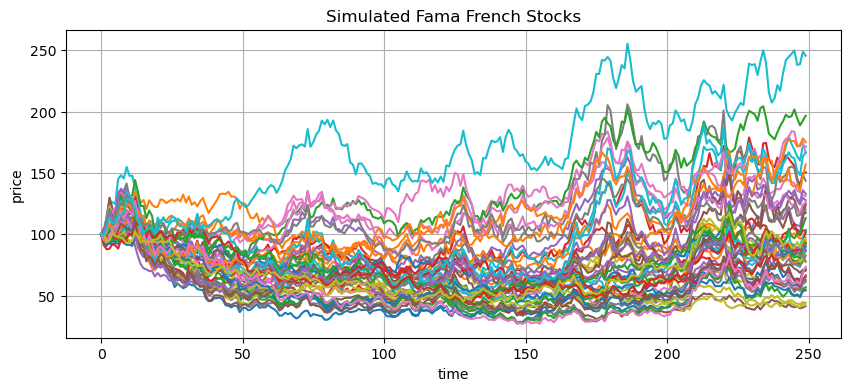

In [1067]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jan 12 17:02:35 2025

@author: joshuakaji
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Params
n_stocks = 50
n_days = 250
initial_price = 100 

# volatility/Drift params (annual)
drift_market = 0.05
vol_market = 0.8
vol_smb = 0.4
vol_hml = 0.2
vol_noise = 0.3 
market_drift = 0.05

# Simulate Fama-French Factors
np.random.seed(42)
market_excess_return = np.random.normal(market_drift*dt, vol_market*np.sqrt(dt), n_days)  # Market factor
smb = np.random.normal(0, vol_smb*np.sqrt(dt), n_days)  # SMB factor
hml = np.random.normal(0, vol_hml*np.sqrt(dt), n_days)  # HML factor

# generate betas for stocks 
betas = {
    "market": np.random.choice([0.5, 1], n_stocks),
    "smb": np.random.choice([-1, 1], n_stocks),
    "hml": np.random.choice([-1, 1], n_stocks),
    "alpha": np.random.choice([0.0], n_stocks)  # stock Alpha
}

# Fama-French diffusion
returns = np.zeros((n_days, n_stocks))
for i in range(n_stocks):
    noise = np.random.normal(0, vol_noise*np.sqrt(dt), n_days)  # Stock Noise
    returns[:, i] = (
        betas["alpha"][i]
        + betas["market"][i] * market_excess_return
        + betas["smb"][i] * smb
        + betas["hml"][i] * hml
        + noise
    )

prices = np.zeros((n_days, n_stocks))
prices[0, :] = initial_price

for t in range(1, n_days):
    prices[t, :] = prices[t - 1, :] * np.exp(returns[t, :])

price_df = pd.DataFrame(prices, columns=[f"Stock_{i+1}" for i in range(n_stocks)])


price_df.plot(legend=False, figsize=(10, 4), grid=True, title=f"Simulated Fama French Stocks", 
             xlabel = "time", ylabel="price")

# log returns
lr_df = np.log(price_df).diff().dropna()


## 2) Impliciting Factors ($F_t $)

In the following 3 sections, we determine the factors (Market, SMB, HML) over time $(F_t)_t $ via 3 different methods: 
- Construction by definition of the factor
- univariate regression 
- Multivariate regression 


### 2.1) Reconstruction of Factors via definition

We take the example of the SMB factor. The HML factor is determined in a similar manner. The Market Factor can be determined by taking the average of all stocks (weighted by market cap) minus the risk free rate. 

By definition, the SMB factor is the average excess returns of small-cap stocks over large-cap stock. The beta of this factor represents the size of the company. The smaller the company, the higher the beta. 

The formula is the following : 

$$
\text{SMB} = \frac{1}{2} \left( \text{Avg Small Stocks} - \text{Avg Big Stocks} \right)
$$

$$
\text{HML} = \frac{1}{2} \left( \text{Avg High Book-Value stocks} - \text{Avg Low Book-Value stocks} \right)
$$

<u>Intuition of HML and SMB formulas </u>: 

Mathematically, the intuition is that we isolate the factors of interest by cancelling out the other factors. This works on the condition that the noise (variations not explained by the factor of interest) is evenly distributed on both sides of the set of high-beta vs low-beta stocks. 

An example of when these formulas would not work to isolate, say, the SMB factor, would be if there was a tendancy for the book value to be higher or lower (ie: HML factor loadings) in smaller or larger stocks. The formulas above would then capture the variations of the HML factor as well as the SMB factor. 






correlation between smb factor obtained by regression vs original smb factor:  0.9921416749642519
correlation between hml factor obtained by regression vs original hml factor:  0.9747671582849534


Text(0.5, 0.98, 'Reconstructed Factors (via definition)\n vs Original Factors')

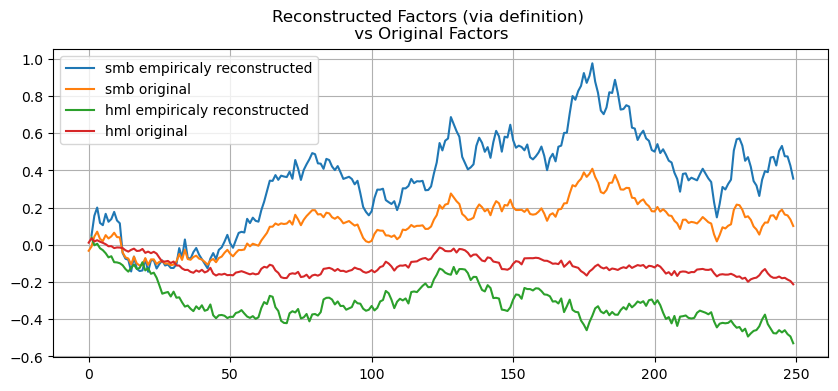

In [1068]:
# Original factors 
factors_orig = pd.DataFrame([market_excess_return, smb, hml], index= ["market", "smb", "hml"]).T


fig, axs = plt.subplots(figsize=(10, 4))
# reconstructing the original Factors from diffusion
for factor in list(betas.keys())[1:-1]:
    middle_threshold = betas[factor].mean()

    # low SMB stocks 
    lg_big = lr_df.loc[:, betas[factor] > middle_threshold]
    lg_small = lr_df.loc[:, betas[factor] < middle_threshold]

    smb_empirical = lg_big.mean(1) - lg_small.mean(1)

    smb_empirical.cumsum().plot(label=f"{factor} empiricaly reconstructed", legend=True, ax=axs)
    factors_orig[factor].cumsum().plot(label=f"{factor} original", legend=True, ax=axs)

    # calculate correlation 
    correlation = np.corrcoef(factors_orig[factor].values[1:], smb_empirical.values)[1, 0]
    print(f"correlation between {factor} factor obtained by regression vs original {factor} factor: ", correlation)

axs.grid()
fig.suptitle("Reconstructed Factors (via definition)\n vs Original Factors")




#### Interpretation : 

Since we modelled the factors independantly and the betas for each stock were also assigned randomly, the formulas work well in impliciting the factors. Althought the scales are different, the correlations calculated between the original factors and the reconstructed/implicited factors are high : 99% and 97% for SMB vs HML respectively. The fact that the HML formula results in a slightly less precice reconstitution of the original factor could be attributed to the fact that the HML factor is less volatile than that of SMB. Therefore, the noise relative to the factor is larger for the HML factor than it is for the SMB factor. 



### 2.2) Impliciting Factors via Univariate Regression - when single $\beta$ known

To determine a factor over time, we can apply a univariate linear regression provided the beta for that factor is known. The precision of the regression depends on whether or not the factor being calculated is correlated to another factor that is driving prices as well. When such a factor exists, the noise (or variations left unexplained by the factor) will likely be skewed. Further, the more weight other unidentified factors have on the returns, the more volatile the noise will become, even if these factors are independant of the factor of interest.



market correlation 0.9408499834344298
smb correlation 0.9921416749642519
hml correlation 0.9747671582849536


Text(0.5, 0.98, ' Univariate Regressions')

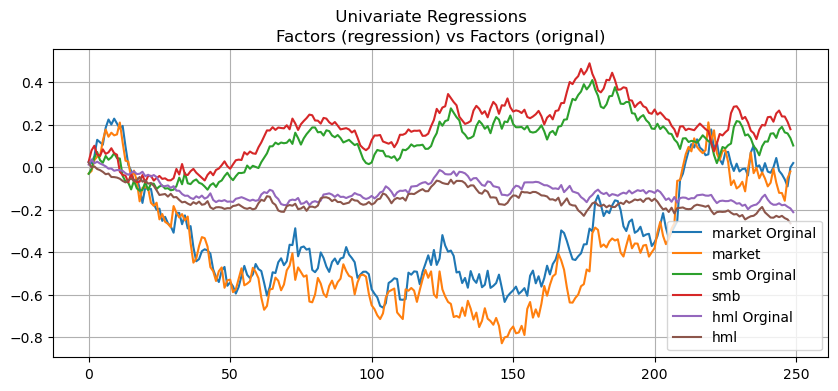

In [1069]:
import numpy as np
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# factor_n =2
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
for factor_n in range(0, 3):
    beta_sml = B[:, factor_n].reshape(-1, 1)
    model.fit(beta_sml, X.T)

    F = model.coef_

    intercept = model.intercept_

    # Predicted values of X using the linear model
    X_pred = model.predict(beta_sml)

    # reconstructed factors 
    factors_regression = pd.DataFrame(F, columns = [list(betas.keys())[factor_n]])

    factors_orig.iloc[:, factor_n].cumsum().plot(ax=axs, label=f"{list(betas.keys())[factor_n]} Orginal")
    factors_regression.cumsum().plot(ax=axs, label=f"{list(betas.keys())[factor_n]} Regression")
    
    # determin correlation
    orig = factors_orig.iloc[1:, factor_n].values
    regress = factors_regression.values.T
    print(list(betas.keys())[factor_n],"correlation",  np.corrcoef(orig, regress)[0, 1])

axs.legend()
axs.grid()
axs.set_title("Factors (regression) vs Factors (orignal)")
fig.suptitle(" Univariate Regressions")
#fig.show()



### 2.3) Impliciting Factors via Multivariate Regression - when all $\beta$s known

When all the betas (ie: $\beta^F, \forall F$) driving prices are known, we can determine all the factors (ie : $ F^\beta_t, \forall \beta ,  \forall t $) simultaneously by applying a mutivariate linear regression.


market 0.9763862567100855
smb 0.9941195346242535
hml 0.9753978907002274


Text(0.5, 0.98, 'Multivariate Regression')

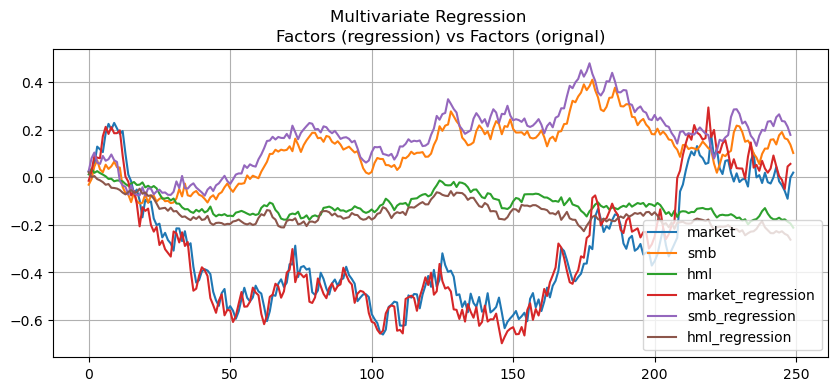

In [1070]:

# Beta factors 
B = np.column_stack(list(betas.values()))[:, :-1]
# log returns 
X = lr_df.values

#print(f"B {B.shape}", f"X {X.shape}")
model = LinearRegression()
model.fit(B, X.T)
F = model.coef_

intercept = model.intercept_
X_pred = model.predict(B)

# reconstructed factors 
factors_regression = pd.DataFrame(F, columns = ["market_regression", "smb_regression", "hml_regression"])

fig, axs = plt.subplots(1, 1, figsize=(10, 4))
factors_orig.cumsum().plot(ax=axs)
factors_regression.cumsum().plot(ax=axs)
axs.grid()
axs.set_title("Factors (regression) vs Factors (orignal)")

# determine correlation between original vs reconstructed factors
for i in range(0, 3):
    orig = factors_orig.iloc[1:, i].values
    regress = factors_regression.iloc[:, i].values
    print(list(betas.keys())[i], np.corrcoef(orig, regress)[0, 1])

fig.suptitle("Multivariate Regression")
#fig.show()

    


## 3) PCA - Determining $F_t$ x $\beta_i$  


PCA allows us to determine both the factors driving the stock prices as well as the stocks sensitivities (betas) to those factors. 

Whether we apply PCA to $X$ or $X^T$ (corresponding repectively to solving for EigenValues x EigenVectors) depends on what axis we want to represent data: on the time axis or the stock axis. 


## 3.1) PCA on $XX^T$ - explaining returns across "stocks" axis

In this section, we apply PCA to the transpose of our returns. This means that the data points that we are condensing into a single value (for a given component) is $(S_t^i)_{t \in [1, 250]}$ for a given data point $i$.


<br>


<details>
  <summary>  PCA on $XX^T$ </summary>
  <img src="source_images/PCA_XXt.jpeg" alt="image"  width="600" />
</details>

By applying PCA to $XX^T$, we condense the stock returns over time to sensitivities $\beta$. 

$$ \forall i \in [1, 50] \quad  (S_t^i)_{t \in [1, 250]} \rightarrow \beta_i $$


difference of reconstructed vs Original Data 1.8578863016723186e-15


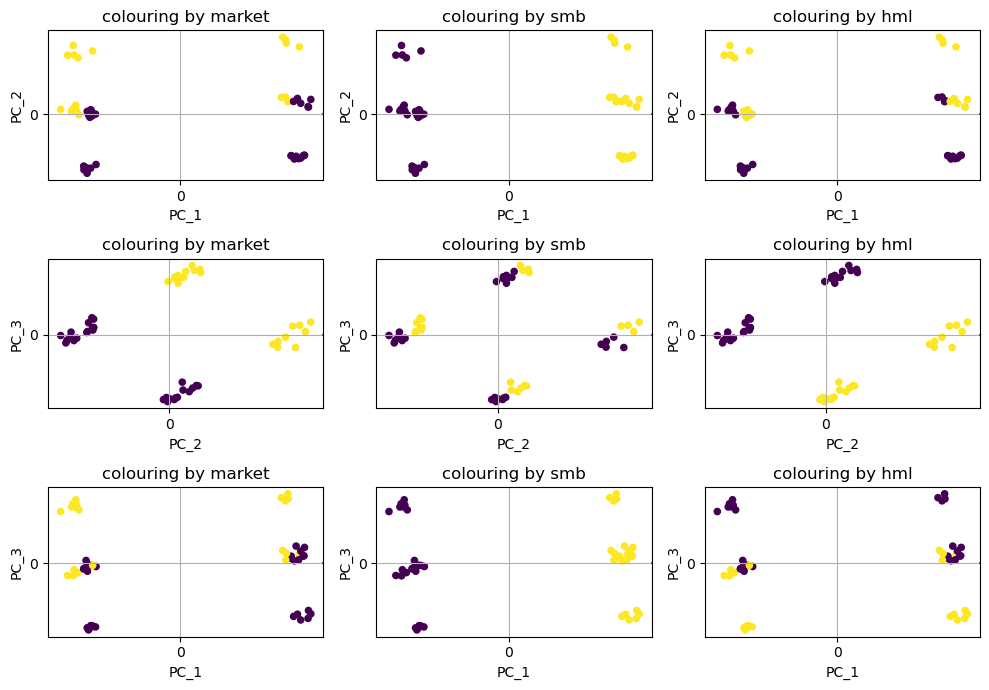

In [1071]:
############################################################
############ 1st PCA on stocks : Applying PCA on stocks(i) for i in [1, n_stocks]
X = (lr_df.T - lr_df.T.mean()).values
#log_returns_standardized = StandardScaler().fit_transform(lr_df.values)
pca = PCA(n_components=X.shape[0])  # Number of components = number of columns
pca_scores = pca.fit(X)  # Project data onto principal components

# princple components
P = pca.components_.T 

# eigen values 
eigenvalues = pca.explained_variance_


A = np.dot(P.T, X.T).T
X_reconstructed = np.dot(P, A.T).T
print("difference of reconstructed vs Original Data", (X_reconstructed - X).sum())

fig, axs = plt.subplots(3, 3, figsize = (10, 7))
factors = ["market", "smb", "hml"]

row_graph = 0
for i, j in [(0, 1), (1, 2), (0, 2)]:
    # plot PC_j vs PC_i
    #j = i+1
    # get first 2 eigen values 
    ei = P[:, i]
    ej = P[:, j]

    # project data of each eigen vector to determin Principle components
    pci = X.dot(ei)
    pcj = X.dot(ej)

    # PC1 should be market, PC2 should be HML => color to identify them on graph 
    PC_ij = pd.DataFrame([pci, pcj], index =[f"PC_{i+1}", f"PC_{j+1}"]).T
    for f in range(0, 3):
        
        colours = np.empty(len(PC_ij))
        factor = factors[f]
        mask_beta_high = betas[factor] > betas[factor].mean()
        mask_beta_low = betas[factor] < betas[factor].mean()
        # colour in high betas vs low betas of factor
        colours[mask_beta_high] = 3
        colours[mask_beta_low] = 2
        PC_ij.plot.scatter(x=0 , y=1, grid=True, color=colours, ax = axs[row_graph, f])
        axs[row_graph, f].axhline("0", 10)
        axs[row_graph, f].axvline("0", 10)
        axs[row_graph, f].set_title(f"colouring by {factor}")
    row_graph+=1

plt.tight_layout()
plt.show()



#### Interpretation of the graphs : 

 <u>Principle component 1 </u>:

The first principle component represents the SMB beta factors. This is clearly seen in the top-centre or the bottom-centre graphs where we see that high vs low SMB stocks are clearly delineated. 

<u>Principle component 2 </u>:

The second principle component represents in part the Market factor and in part the HML factor. This is seen by the top-left and top-right graphs where we see that high vs low market beta stocks (respectively, high vs low HML beta stocks) partially delineated. 

<u>Principle component 3 </u>:

The third principle component represents in part the Market factor and in part the HML factor. This is evidenced by the bottom-left and bottom-right graphs where we see that high vs low market beta stocks (respectively, high vs low HML stocks) are partially delineated. 

## 3.2) PCA on $X^TX$ - explaining returns across "time" axis


In this section, we apply PCA to the returns (non transposed). This means that the data points that we are condensing into a single value (for a given principle component) is $(S_t^i)_{i \in [0, 50]}$ for a given data point $t$. 


<br>


<details>
  <summary>  PCA on $X^TX$ </summary>
  <img src="source_images/Pca_XtX.jpeg" alt="image"  width="600" />
</details>


By applying PCA to $X^TX$, we condense the returns of all stocks at a point in time $t$ to factor variations at $t$. 

$$ \forall t \in [0, 250] \quad(S_t^i)_{i \in [0, 50]} \rightarrow F_t $$

###  3.2.1) Determining EigenVectors and EigenValues



In [1072]:
############################################################
############ 2nd PCA - Projecting ret(t) for t in [0, 250] 
X = (lr_df - lr_df.mean()).values
#log_returns_standardized = StandardScaler().fit_transform(lr_df.values)
pca = PCA(n_components=X.shape[1]) 
pca_scores = pca.fit(X)  # Project data onto principal components

# Eigen vector matrix
P = pca.components_.T 

# eigen values 
eigenvalues = pca.explained_variance_


A = np.dot(P.T, X.T).T
X_reconstructed = np.dot(P, A.T).T
print("difference", (X_reconstructed - X).sum())


difference -3.2827744429059225e-15


###  3.2.2) Explained Variance in Reduced Space 


The explained variance for a given principal component indicates how much of the total variability (variance) in the data is captured by that principal component. 
A high explained variance means a lot of the information remains after projecting on that component. 

$$
\text{Explained Variance Ratio for Component } i = \frac{\lambda_i}{\sum_{j=1}^n \lambda_j}
$$

The cumulative explained variance for the k-th principal component indicates how much of the total variability in the data is captured by the first k principal components. A high explained variance means a lot of the information remains after projecting on the space composed of the first k eigenvectors. 
$$
\text{Cumulative Explained Variance } k = \frac{\sum_{i=1}^k \lambda_i}{\sum_{j=1}^n \lambda_j}
$$

<u>Note</u>: Variance is not additive however eigenvectors are by construction orthogonal, therefore, the variance of data projected on this space is simply the sum of the variances of the data projected on each eigenvector individually. 

<Axes: xlabel='Principle Component', ylabel='variance explained'>

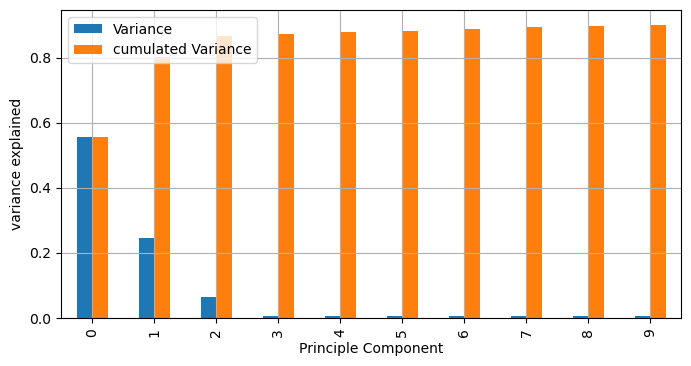

In [1073]:
# calculate explained varience as % 
explained_variance = eigenvalues/eigenvalues.sum()
"""
explained_variance = (reconstruction**2).sum() # sum of squared elements
explained_variance = np.dot(pc1, X.T.dot(X).dot(pc1)) # pc1' (X'X) pc1
"""
summary_variance = pd.DataFrame(explained_variance)
summary_variance[1] = summary_variance.cumsum()
summary_variance.columns = ["Variance", "cumulated Variance"]

summary_variance.iloc[:10].plot.bar(xlabel="Principle Component", 
                                                 ylabel="variance explained", 
                                   figsize=(8, 4), grid=True)


<u>Interpretation </u> : 

In the graph above the explained variance per individual principal component is shown (blue). These values are proportional to the explanatory power of a given principle component. 

Additionally, the cumulative variance is shown in orange. This representation is usefull when determining the number of principle componants on which we want to project our data. 

We notice that the first 3 principle components contain the largest amounts of information. Together, they explain almost 90% of the total variance of the data. 

The fact that there are 3 major principle components coincides with the fact that 

### 2.3) Projecting stock returns on increasing number of Principle Componants 



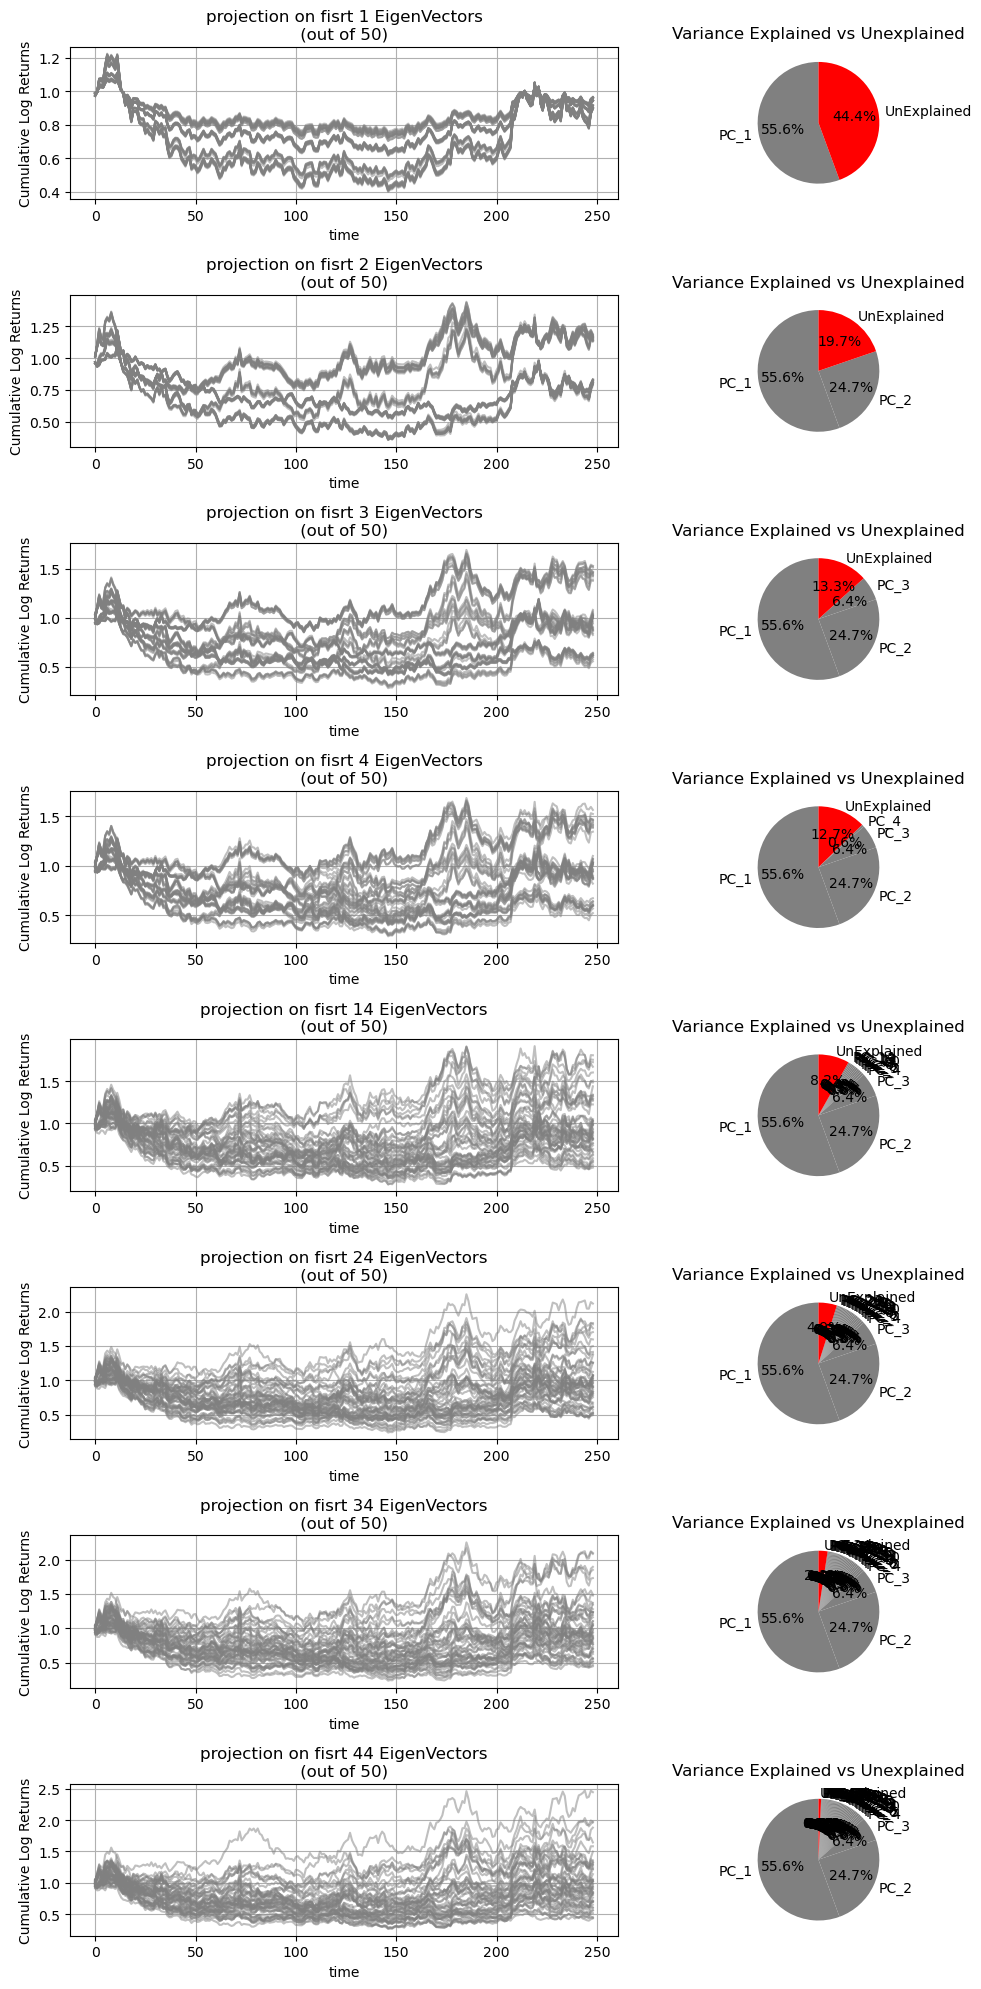

In [1074]:
from itertools import chain

chain_rng = chain(range(1, 3+1), range(3+1, n_stocks+1, 10))

fig, axs = plt.subplots(len(list(chain_rng)), 2, figsize=(10, 20), gridspec_kw={'width_ratios': [3, 1]})

A = np.dot(P.T, lr_df.values.T).T  
counter = 0
for dim in chain(range(1, 3+1), range(3+1, n_stocks+1, 10)):
    # plot returns on increasing space of eigen vectors
    X_reconstructed = np.dot(P[:, :dim], A[:, :dim].T).T
    df_reconst = pd.DataFrame(X_reconstructed).cumsum()
    pd.DataFrame(X_reconstructed).cumsum().apply(np.exp).plot(legend=False, title=f"projection on fist {dim} EigenVectors", grid=True,
                                                color='grey', alpha=0.5, 
                                                ax = axs[counter, 0], 
                                               xlabel = "time", ylabel = "Cumulative Log Returns")
    axs[counter, 0].set_title(f"projection on fisrt {dim} EigenVectors\n (out of {n_stocks}) ")
    
    # plot pie chart with variance contribution 
    v2 = summary_variance.iloc[:dim]
    v2.index = [f"PC_{i}" for i in range(1, dim+1)] 
    v3 = v2[['Variance']].T
    v3["UnExplained"] = 1- v3.sum(1)

    sizes = v3.iloc[0].values  
    labels = v3.columns 

    colors = ['grey'] * (len(sizes) - 1) + ['red']  # Red for unexplained variance

    axs[counter, 1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    axs[counter, 1].set_title('Variance Explained vs Unexplained')
    
    counter+=1

plt.tight_layout()
fig.subplots_adjust(wspace=0.3)

#### Interpretation 

The the graphs represents the stock paths when projected on an increasing number of principal components. As the the number of principal components used to describe the returns increase, the paths converge to the original data. We notice however that first 3 components capture to a significant degree the trend of all stocks.

Beyond the first 3 principal components, the explanatory power of components becomes negligeable.

### 2.4) Projecting stock returns on Individual Principle Componants 

Plotting first 5 principle components. We see that first 3 are factors, 4th and 5th are noise 

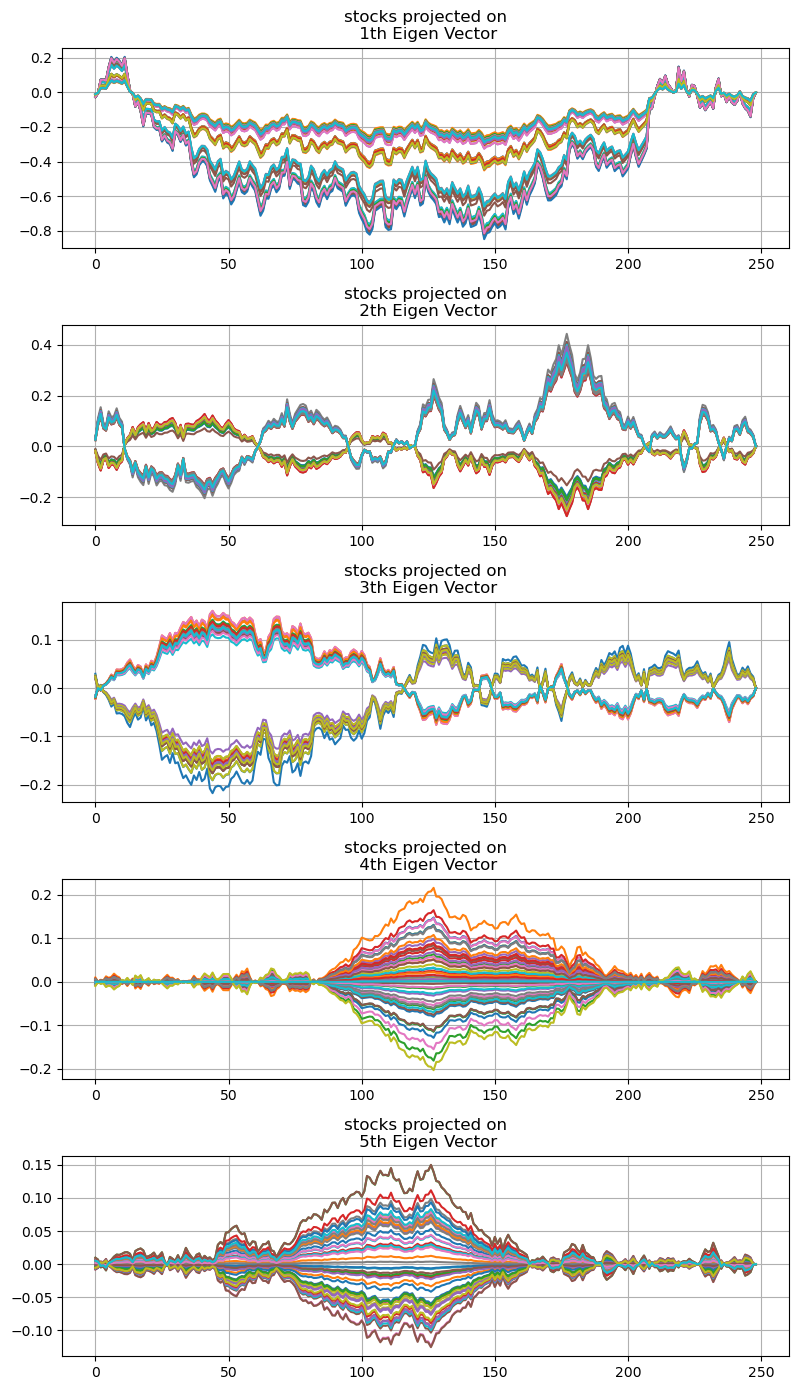

In [1076]:
############################################################
#### Projection on first 5 Principle components 
fig, axs = plt.subplots(5, 1, figsize=(8, 14))
for i in range(0, 5):
    pc_i = P[:, i]  # ith principal component
    projection = X.dot(pc_i)  # Shape (252,), projection of X onto pc1
    reconstruction = np.outer(projection, pc_i)  # X*PC1
    pd.DataFrame(reconstruction).cumsum().plot(legend=False, title=f"stocks projected on\n {i+1}th Eigen Vector", ax =axs[i], grid=True)

plt.tight_layout()

### 2.5) Componant 1 : Market Factor 


When a factor is independant from the other factors driving the data and when it has the most explanatory power, it will usually apear as the first component. 

By design we made the market factor the biggest driver of our stock simulations by increasing the volatility of the market factor and by applying high market sensitivities (beta) for the stocks. 

<br>


<details>
  <summary>  Principle Component 1 - Market Factor </summary>
  <img src="source_images/PC1_PCA_across_time.png" alt="image"  width="900" />
</details>



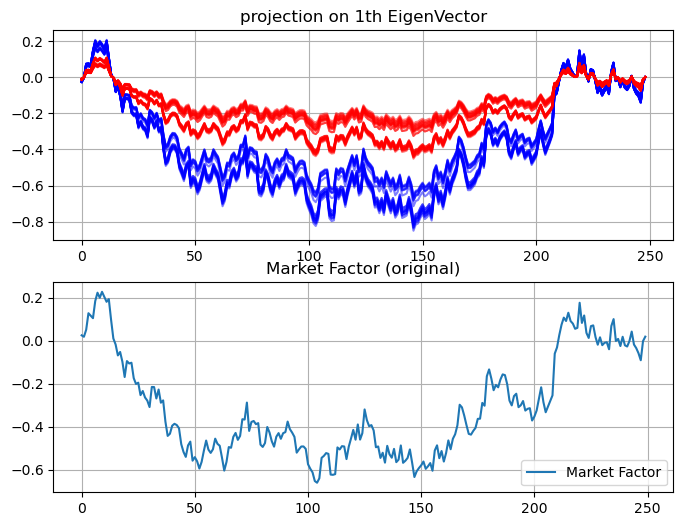

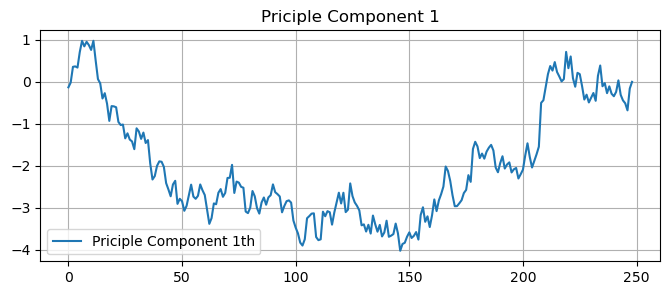

In [1077]:
############################################################
#### Projection on first PC : Market factor 
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
i = 0
eigen_i = P[:, i]  # ith principal component
projection = X.dot(eigen_i)  # Shape (252,), projection of X onto pc1
PC_i = pd.Series(X.dot(eigen_i))
lr_proj = pd.DataFrame(np.outer(projection, eigen_i))  # X*PC1

mask_beta_market_high = betas["market"] == 1
mask_beta_market_low = betas["market"] == 0.5

lr_proj.loc[:, mask_beta_market_high].cumsum().plot(legend=False, title=f"projection on {i+1}th EigenVector", 
                                                    ax =axs[0], grid=True, color='blue', alpha=0.5)
lr_proj.loc[:, mask_beta_market_low].cumsum().plot(legend=False, title=f"projection on {i+1}th EigenVector", 
                                                   ax =axs[0], grid=True, color='red', alpha=0.5)

# plot market factor to compare 
pd.Series(market_excess_return).cumsum().plot(title=f"Market Factor (original)", ax =axs[1], grid=True, label=f"Market Factor")
axs[1].legend()
plt.show()

PC_i.cumsum().plot(grid=True, label = f"Priciple Component {i+1}th", figsize=(8, 3), legend=True, 
                  title= f"Priciple Component {i+1}")
#plt.legend()
#plt.show()
plt.show()
#plt.scatter(eigen_i/eigen_i[0], betas['market'])
#plt.xlabel("Eigen Vector 1 (rescaled)")
#plt.ylabel("Beta Market")



#### Interpretation

The first graph represents the projection of the stock (cumulative log-returns) on the first principle component. 
The second graph is the original market factor that we simulated. Note that the first and second graphs are strikingly similar, confirming that the first principle component is indeed the Market factor. 
The third graph is the 1st principle component represented in the original space. The third and second graphs seem identical besides the scale.  

<u>Note</u> :
Whilst we constructed the stock simulations such that the market factor would emerge as the 1st principal component, this is usually what is observed in practice as well. 

### 2.6) Componant 2 : SMB Factor (Size)

By design, we constructed our stocks such that the SMA factor was the second highest contributor to the log-returns of our stocks: second highest volatility (after market factor), with similar range of stock sensitivities as the HML factor. We therefore expect the second principle component to represent the SMA factor.  

/var/folders/gp/smgn_r6x14nbx9c9rdp4__b40000gn/T/ipykernel_34460/1751129342.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


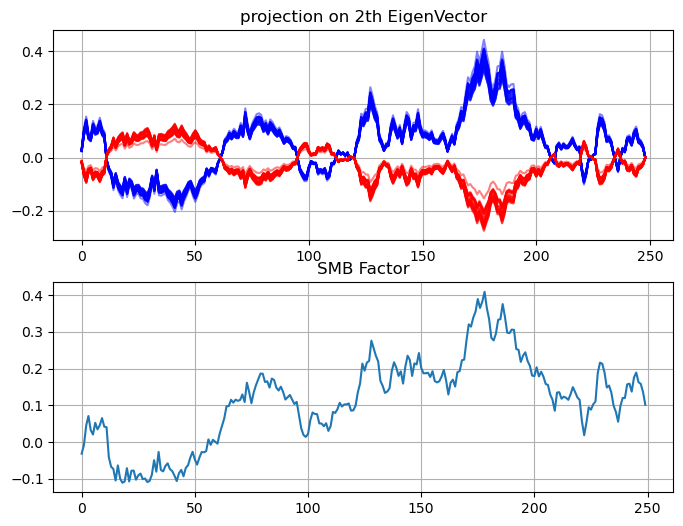

In [1078]:

############################################################
#### Projection on first PC : SMB 
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
i = 1
eigen_i = P[:, i]  # ith principal component
PCi = X.dot(eigen_i)  # Shape (252,), projection of X onto pc1
lr_proj = pd.DataFrame(np.outer(PCi, eigen_i))  # X*PC1

# tODO, color the beta component 
beta_smb_long = betas['smb'] == 1 
beta_smb_short = betas['smb'] == -1

lr_proj.loc[:, beta_smb_long].cumsum().plot(legend=False, title=f"projection on {i+1}th EigenVector", 
                                                    ax =axs[0], grid=True, color='blue', alpha=0.5)
lr_proj.loc[:, beta_smb_short].cumsum().plot(legend=False, title=f"projection on {i+1}th EigenVector", 
                                                   ax =axs[0], grid=True, color='red', alpha=0.5)

# plot SMB factor to compare 
pd.Series(smb).cumsum().plot(title=f"SMB Factor", ax =axs[1], grid=True)
fig.show()


#### Interpretation

The first graph represents the stock paths (cumulative log-returns) projected onto the second principle component. 
The blue paths represent the stocks that were simulate with $\beta = 1 $, whilst the red paths represent stocks with $\beta = -1 $.

The second graph is the original SMB factor that we simulated at the begining. The similarity of the projected paths with the SMB factor confirms that the second principle component represents the SMB factor. 



### 2.7) Componant 3 : HML Factor (Book Value)

The only factor that has not been represented in the first two principle components is the HML factor. 

/var/folders/gp/smgn_r6x14nbx9c9rdp4__b40000gn/T/ipykernel_34460/2178096935.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


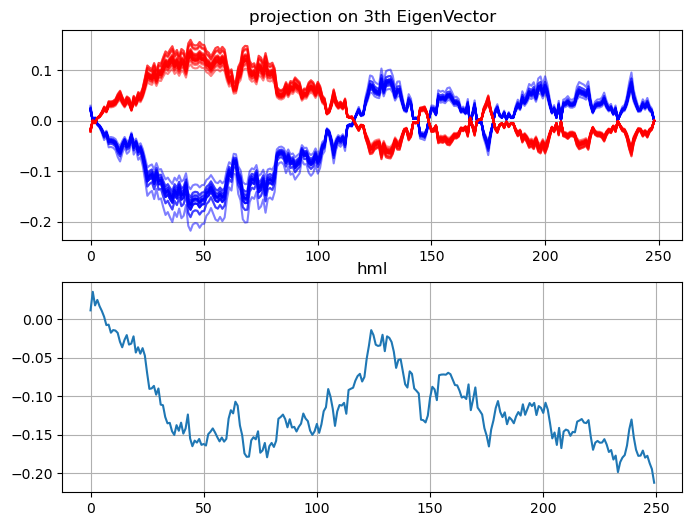

In [1079]:

############################################################
#### Projection on third PC : BMS 
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
i = 2
evi = P[:, i]  # ith principal component
PCi = X.dot(evi)  # Shape (252,), projection of X onto pc1
lr_proj = pd.DataFrame(np.outer(PCi, evi))  # X*PC1

# tODO, color the beta component 
beta_hml_long = betas['hml'] == 1 
beta_hml_short = betas['hml'] == -1

lr_proj.loc[:, beta_hml_long].cumsum().plot(legend=False, title=f"projection on {i+1}th EigenVector", 
                                                    ax =axs[0], grid=True, color='blue', alpha=0.5)
lr_proj.loc[:, beta_hml_short].cumsum().plot(legend=False, title=f"projection on {i+1}th EigenVector", 
                                                   ax =axs[0], grid=True, color='red', alpha=0.5)

# plot HML factor to compare 
pd.Series(hml).cumsum().plot(title=f"hml", ax =axs[1], grid=True)
fig.show()



#### Interpretation 
The log returns projected on the 3rd principal component (first graph) is similar to the original HML factor (second graph). The 3rd principal component therefore represents the HML factor. 


### 2.8) Componant 4 and above  : Noise

Now that we have matched the first three principal components to the three factors (market, SMB, HML), we do not expect to find any emerging patterns from the rest of the principal components. These components fit for the noise that we added to the stock returns. 


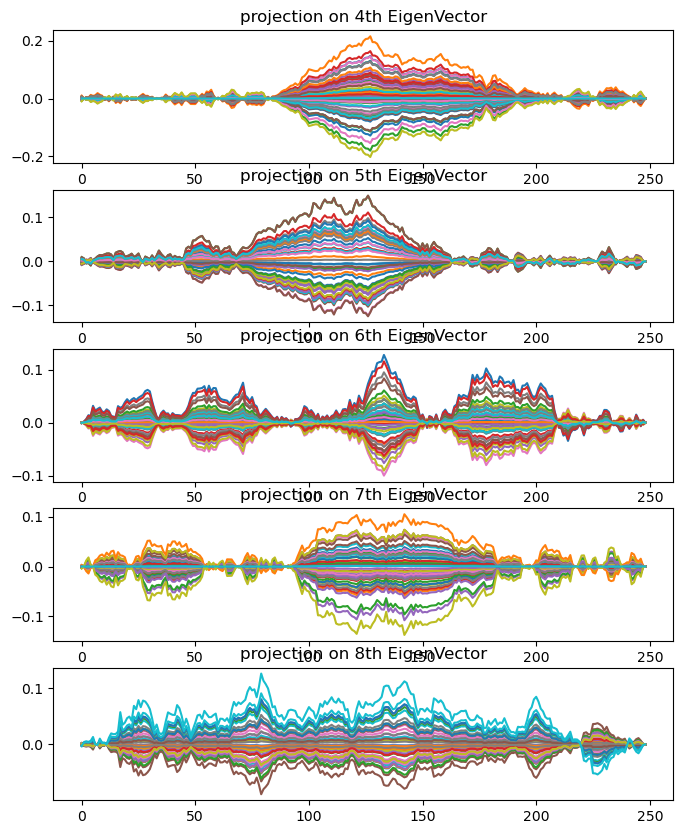

In [1080]:
############################################################
#### Projection on 4th, 5th, ...  : Expected Noise 
fig, axs = plt.subplots(5, 1, figsize=(8, 10))
for i in range(3, 3+ 5):
    ev_i = P[:, i]  # ith eigenvector
    projection = X.dot(ev_i)  # Shape (252,), projection of X onto pc1
    reconstruction = np.outer(projection, ev_i)  # X*PC1
    pd.DataFrame(reconstruction).cumsum().plot(legend=False, title=f"projection on {i+1}th EigenVector", ax =axs[i-3])


#### Interpretation

The projections of stock paths onto principal components 4 and higher exhibit sporadic and unstructured behavior, lacking discernible patterns or trends. This confirms our expectations that these components capture noise. 